In [19]:
import cirq
import numpy as np
import matplotlib.pyplot as plt
# import cirq_google
from numpy import linalg as LA
from math import log, e

# print the supremacy chip
#print(cirq_google.Sycamore)

In [20]:
# These are three qubits on a line
qubits = cirq.LineQubit.range(3)
a = qubits[0]
b = qubits[1]
c = qubits[2]

# This is a collection of operations
# Each operation is a gate
ops = [cirq.H(a), cirq.H(b), cirq.CNOT(b, c), cirq.H(b)]
circuit = cirq.Circuit(ops)

# print circuit diagram
print(circuit)

0: ───H───────────

1: ───H───@───H───
          │
2: ───────X───────


In [21]:
def Bell(n):
    q_chain = cirq.LineQubit.range(2)
    bell = cirq.Circuit()

    bell.append(cirq.H(q_chain[0]))
    bell.append(cirq.CNOT(q_chain[0],q_chain[1]))
    
    if n == 1:
        return bell
    elif n==2:
        bell.append(cirq.Z(q_chain[1]))
        return bell
    elif n==3:
        bell.append(cirq.X(q_chain[1]))
        return bell
    elif n==4:
        bell.append(cirq.X(q_chain[1]))
        bell.append(cirq.Z(q_chain[0]))
        return bell

bell = Bell(4)
print(bell) #1:

simulator = cirq.Simulator()
result = simulator.simulate(bell)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation())

0: ───H───@───Z───
          │
1: ───────X───X───
Bra-ket notation for the wavefunction:
0.71|01⟩ - 0.71|10⟩


# Exercise 4

In [22]:
import random
from math import pi 

random.seed(41)

# qubit order:
# Message
# Alice
# Bob

# creating basics of circuit
qubits = 3
q_chain = cirq.LineQubit.range(qubits)
preparation = cirq.Circuit()
teleportation = cirq.Circuit()
message = q_chain[0]
alice = q_chain[1]
bob = q_chain[2]

# preparing the random state on qubit 0 and the Bell state on qubit 2 and 3

t = pi*random.uniform(0, 1)

gate = cirq.ry(t)

preparation.append(gate(message))
teleportation.append(gate(message))

teleportation.append(cirq.H(alice))
teleportation.append(cirq.CNOT(alice,bob))

# teleportation measurement and correction

teleportation.append(cirq.CNOT(message,alice))
teleportation.append(cirq.H(message))

teleportation.append(cirq.measure(message,alice))

teleportation.append(cirq.CZ(message,bob))
teleportation.append(cirq.CNOT(alice,bob))
            
print('\n', teleportation, '\n')
            
simulator = cirq.Simulator()

trials = 4

for i in range(trials):
	preparation_result = simulator.simulate(preparation)
	teleportation_result = simulator.simulate(teleportation)

	print('First qubit state after preparation \t System state after teleportation')
	print(preparation_result.dirac_notation(), '\t\t\t' ,teleportation_result.dirac_notation())


 0: ───Ry(0.381π)───────@───H───M───@───────
                       │       │   │
1: ───H────────────@───X───────M───┼───@───
                   │               │   │
2: ────────────────X───────────────@───X─── 

First qubit state after preparation 	 System state after teleportation
0.83|0⟩ + 0.56|1⟩ 			 0.83|010⟩ + 0.56|011⟩
First qubit state after preparation 	 System state after teleportation
0.83|0⟩ + 0.56|1⟩ 			 -0.83|110⟩ - 0.56|111⟩
First qubit state after preparation 	 System state after teleportation
0.83|0⟩ + 0.56|1⟩ 			 0.83|010⟩ + 0.56|011⟩
First qubit state after preparation 	 System state after teleportation
0.83|0⟩ + 0.56|1⟩ 			 0.83|000⟩ + 0.56|001⟩


In [23]:
random.seed(42)

q_chain = cirq.LineQubit.range(1)
message_test = cirq.Circuit()

t = pi*random.uniform(0, 1)

gate = cirq.ry(t)

message_test.append(gate(message))

print(message_test)
simulator = cirq.Simulator()
result = simulator.simulate(message_test)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation())


0: ───Ry(0.639π)───
Bra-ket notation for the wavefunction:
0.54|0⟩ + 0.84|1⟩


# Exercise 6:

In [24]:
from numpy import cos, sin
from math import sqrt
import matplotlib.pyplot as plt 

def Population(w,wo,w1,t):
	Omega = sqrt(w1**2 + (w-wo)**2)
	population = (w1*sin(Omega*t/2)/Omega)**2
	return population

def U(w,wo,w1,t,dt):
	q_chain = cirq.LineQubit.range(1)
	troter = cirq.Circuit()

	N = int(t/dt)
	
	thetaz = -wo*dt
	thetax = 2*w1*dt
	
	for n in range(N):
		rx = cirq.rx(thetax*cos(w*n*dt))
		rz = cirq.rz(thetaz)
		troter.append(rz(q_chain[0]))
		troter.append(rx(q_chain[0]))        
	return troter, q_chain


def Troterization(w,wo,w1,t,dt, mode='simulate', noise=''):
	
	reps = 10000
	troter, q_chain = U(w,wo,w1,t,dt)
	simulator = cirq.Simulator()

	if mode == 'tomography':
		sampler = cirq.DensityMatrixSimulator()

		result = cirq.experiments.state_tomography(sampler=sampler, qubits=q_chain, circuit= troter, repetitions=reps)

		rho =  result._density_matrix
		population = abs(rho[1,1])**2
		return population 
	
	if mode == 'run':

		troter.append(cirq.measure(q_chain[0], key='0'))
		result = simulator.run(troter, repetitions=reps)
		counts = result.histogram(key = '0') 
		# population for state |1> := prob(measurement=1)
		population = counts[1]/reps
		return population
	elif mode == 'simulate':
		result = simulator.simulate(troter)
		#print('Bra-ket notation for the wavefunction:')
		#print(result.dirac_notation())
		#print('Population of state |1>')
		population = abs(result.final_state_vector[-1])**2
		#print(np.around(population, 3))
		return population
		
	elif mode == 'noise':
		troter.append(cirq.measure(q_chain[0], key='0'))
		result = cirq.sample(program=troter, noise=noise, repetitions=reps) # type(result) = <class 'cirq.study.result.ResultDict'>
		# type(histogram) = <class 'collections.Counter'>
		counts = result.histogram(key = '0') 
		# population for state |1> := prob(measurement=1)
		population = counts[1]/reps
		return population
	
	else:
		raise Exception('Not a valid mode: {}'.format(mode))

In [56]:
# ts = np.linspace(0.2,4,100)
t = 4
dt = 0.05
ts = np.linspace(0, t, int(t/dt))

pop_a = []
theo_a = []
for t in ts:
    w, wo, w1 = 25.5, 25, 2
    theo_a.append(Population(w,wo,w1,t))
    pop_a.append(Troterization(w,wo,w1,t,dt,'run'))
    
ws = np.arange(10,40,0.2)
w0, w1 = 25, 2
delta = np.arange(10-w0, 40-w0, 0.2)
pop_b = []
theo_b = []
for w in ws:
    t = pi/w1
    theo_b.append(Population(w,wo,w1,t))
    pop_b.append(Troterization(w,wo,w1,t,dt,'run'))

t = 4
dt = 0.05
timeIntervals2 = np.linspace(0, t, int(t/dt))

pop_c = []
theo_c = []
w, w0, w1 = 2, 2, 2
for t in timeIntervals2:
    theo_c.append(Population(w,w0,w1,t))
    pop_c.append(Troterization(w,w0,w1,t,dt,'run'))

t = 1.4
dt = 0.05
timeIntervals3 = np.linspace(0, t, int(t/dt))

pop_d = []
theo_d = []
for t in timeIntervals3:
    w, w0, w1 = 3, 1, 6
    theo_d.append(Population(w,w0,w1,t))
    pop_d.append(Troterization(w,w0,w1,t,dt,'run'))

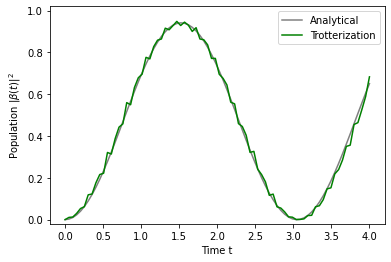

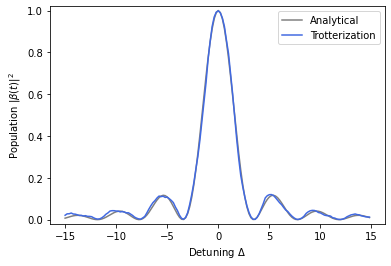

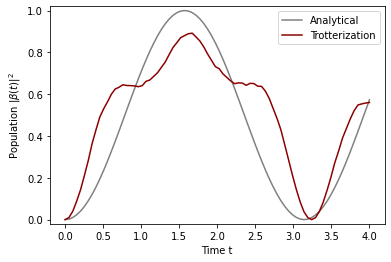

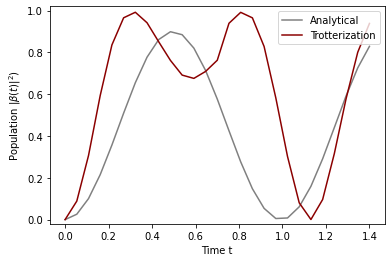

In [58]:
plt.figure()
plt.xlabel(r'Time t')
plt.ylabel(r'Population $|\beta(t)|^2$')
plt.plot(ts, theo_a, 'gray', label='Analytical')
plt.plot(ts, pop_a, 'green', label='Trotterization')
plt.ylim(-0.02, 1.02)
plt.legend()
plt.savefig("exercise06_01.png")
plt.show()

plt.figure()
plt.xlabel(r'Detuning $\Delta$')
plt.ylabel(r'Population $|\beta(t)|^2$')
plt.plot(delta, theo_b, 'gray', label='Analytical')
plt.plot(delta, pop_b, 'royalblue', label='Trotterization')
plt.ylim(-0.02, 1.02)
plt.legend()
plt.savefig("exercise06_02.png")
plt.show()

plt.figure()
plt.xlabel(r'Time t')
plt.ylabel(r'Population $|\beta(t)|^2$')
plt.plot(timeIntervals2, theo_c, 'gray', label='Analytical')
plt.plot(timeIntervals2, pop_c, 'darkred', label='Trotterization')
plt.ylim(-0.02, 1.02)
plt.legend()
plt.savefig("exercise06_03.png")
plt.show()

plt.figure()
plt.xlabel(r'Time t')
plt.ylabel(r'Population $|\beta(t)|^2$')
plt.plot(timeIntervals3, theo_d, 'gray', label='Analytical')
plt.plot(timeIntervals3, pop_d, 'darkred', label='Trotterization')
plt.ylim(-0.02, 1.02)
plt.legend()
plt.savefig("exercise06_04.png")
plt.show()

# Exercise 7

In [27]:
pop_noise = []
noise = cirq.ConstantQubitNoiseModel(cirq.GeneralizedAmplitudeDampingChannel(p=0.5,gamma=0.02))

ts_new = np.linspace(0.2,10,100)
dt = 0.05

for t in ts_new:
    w, wo, w1 = 25.5, 25, 2
    pop_noise.append(Troterization(w,wo,w1,t,dt,'noise',noise))

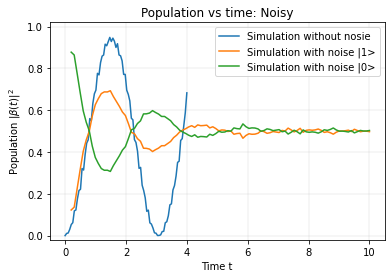

In [59]:
plt.figure()
plt.xlabel('Time t')
plt.ylabel(r'Population $|\beta(t)|^2$')
plt.plot(ts, pop_a, label='Simulation without nosie')
plt.plot(ts_new, pop_noise, label='Simulation with noise |1>')
plt.plot(ts_new, 1-np.array(pop_noise), label='Simulation with noise |0>')
plt.ylim(-0.02, 1.02)
plt.legend()
plt.grid(linestyle='-', linewidth=0.2)
plt.show()

In [31]:
ps = [0,0.5,0.9,1]
gammas = [0,0.02,0.1]

populations = np.zeros((len(ps),len(ts),len(gammas)))

dt = 0.05
w, wo, w1 = 25.5, 25, 2

for i, p in enumerate(ps):
    for j, gamma in enumerate(gammas):
        for k, t in enumerate(ts):
            noise = cirq.ConstantQubitNoiseModel(cirq.GeneralizedAmplitudeDampingChannel(p=p,gamma=gamma))
            populations[i,k,j] = (Troterization(w,wo,w1,t,dt,'noise',noise))

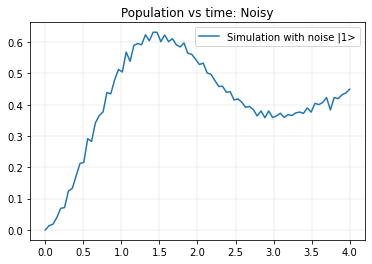

In [32]:
plt.figure()
plt.title('Population vs time: Noisy')
plt.plot(ts, populations[2,:,1], label='Simulation with noise |1>')
plt.legend()
plt.grid(linestyle='-', linewidth=0.2)
plt.show()

***Notes***:

For $p = 1$ the channel reduces to the normal amplitude damping channel \
For $p = 0$ the channel behaves like an amplitude enhancing channel, driving the system to the $|1><1|$ state

# Exercise 8:

In [33]:

def Expectation(prepare='', ops='', reps=int(1e6), debug=False):

    """ 
    prepare: gates to prepare initial state
    ops: operators to change the Z measurement basis into another basis
    examples: 
    - for measurement in X basis: H    
    - for measurement in Y basis: Sdagger, H
    """

    qubits = cirq.LineQubit.range(1)
    q0 = qubits[0]

    simulator = cirq.Simulator(seed=np.random.seed(2))
    measurement_op = cirq.Circuit()

    if prepare:
        measurement_op.append(p(q0) for p in prepare)
    if ops:
        measurement_op.append(p(q0) for p in ops)

    measurement_op.append(cirq.measure(q0, key='0'))

    if debug:
        print(measurement_op)

    result = simulator.run(measurement_op, repetitions = reps)
    counts = result.histogram(key = '0')

    print(counts)

    N0, N1 = counts[0], counts[1]

    return (N0-N1)/reps


prepare = [cirq.H, cirq.T]

ops_X = [cirq.H]
ops_Y = [cirq.S**-1, cirq.H]

EZ = Expectation(prepare, debug=True)
EX = Expectation(prepare, ops_X, debug=True)
EY = Expectation(prepare, ops_Y, debug=True)

print('Expectation value of Z gate: ', EZ)
print('Expectation value of X gate: ', EX)
print('Expectation value of Y gate: ', EY)


0: ───H───T───M('0')───
Counter({0: 500488, 1: 499512})
0: ───H───T───H───M('0')───
Counter({0: 853353, 1: 146647})
0: ───H───T───S^-1───H───M('0')───
Counter({0: 853353, 1: 146647})
Expectation value of Z gate:  0.000976
Expectation value of X gate:  0.706706
Expectation value of Y gate:  0.706706


# Exercise 9:

Idea: to get the state we can diagonalize the matrix, and obtain the first (and only) eigen state, that would be our initial pure state

In [34]:
# calculating the c_i for the density matrix

rho_tomo = 0.5*np.eye(2, dtype = np.complex128)

Es = [EZ, EX, EY] # list of expectation values

paulis = [cirq.Z, cirq.X, cirq.Y] # list of pauli gates
paulis_matrices = [cirq.unitary(P) for P in paulis] # list of pauli gates as numpy arrays

for i in range(3):
     c = 0.5*Es[i]
     rho_tomo += c*paulis_matrices[i]
    
print(rho_tomo)

w_tomo, v_tomo = LA.eig(rho_tomo)

print(abs(w_tomo[0])**2)
v_tomo[:,0]

[[0.500488+0.j       0.353353-0.353353j]
 [0.353353+0.353353j 0.499512+0.j      ]]
0.9994337665462171


array([0.70745196+0.j       , 0.4997558 +0.4997558j])

In [35]:
#circuit for state tomography
sampler = cirq.DensityMatrixSimulator()

qchain = cirq.LineQubit.range(1)
q0 = qchain[0]

ops = [cirq.H(q0), cirq.T(q0)]

circuit9 = cirq.Circuit(ops)

# print circuit diagram
print(circuit9)

simulator = cirq.Simulator()
result = simulator.simulate(circuit9)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation())

result = cirq.experiments.state_tomography(sampler=sampler, qubits=qchain, circuit= circuit9, repetitions=1000000)

rho =  result._density_matrix

print(rho)
print(rho[0,0])


w_function, v_function = LA.eig(rho)

print(abs(w_function[0])**2)
v_function[:,0]

0: ───H───T───
Bra-ket notation for the wavefunction:
0.71|0⟩ + (0.5+0.5j)|1⟩
[[0.499299-2.26623326e-17j 0.353993-3.53156000e-01j]
 [0.353993+3.53156000e-01j 0.500701+5.55111512e-17j]]
(0.49929899999999994-2.2662332591841973e-17j)
9.421734375406304e-10


array([ 0.70760226+0.j        , -0.50024045-0.49905765j])

In [36]:
# comparison:
print(LA.norm(rho_tomo - rho))

0.0019298341897688316


# Exercise 10

In [38]:
dt = 0.05
ts_10 = np.linspace(0.2,2,100)
pop_10 = []
theo_10 = []
for t in ts_10:
    w, wo, w1 = 25.5, 25, 2
    theo_10.append(Population(w,wo,w1,t))
    pop_10.append(Troterization(w,wo,w1,t,dt,'tomography'))

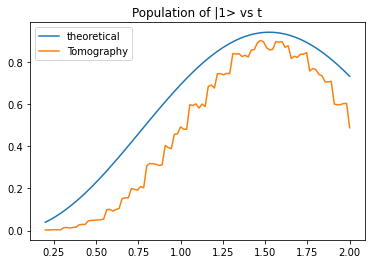

In [39]:
plt.figure()
plt.title('Population of |1> vs t')
plt.plot(ts_10, np.array(theo_10), label='theoretical')
plt.plot(ts_10, pop_10, label='Tomography')
plt.legend()
plt.show()

# Exercise 11:

In [40]:
"""Define a custom gate with a parameter."""
class RXZ(cirq.Gate):
    def __init__(self, b):
        super(RXZ, self)
        self.b = b

    def _num_qubits_(self):
        return 2

    def _unitary_(self):
        return np.array([
            [np.cos(self.b), 0.0, 1j*np.sin(self.b),  0.0],
            [0.0,  np.cos(self.b), 0.0,  -1j*np.sin(self.b)],
            [1j*np.sin(self.b),  0.0, np.cos(self.b),  0.0],
            [0.0,  -1j*np.sin(self.b), 0.0, np.cos(self.b)]
        ])

    def _circuit_diagram_info_(self, args):
        return f"RXZ({self.b})",  f"RXZ({self.b})"
    
class RZX(cirq.Gate):
    def __init__(self, b):
        super(RZX, self)
        self.b = b

    def _num_qubits_(self):
        return 2

    def _unitary_(self):
        return np.array([
            [np.cos(self.b), 1j*np.sin(self.b), 0.0,  0.0],
            [1j*np.sin(self.b), np.cos(self.b), 0.0,  0.0],
            [0.0, 0.0, np.cos(self.b), -1j*np.sin(self.b)],
            [0.0, 0.0, -1j*np.sin(self.b), np.cos(self.b)]
        ])

    def _circuit_diagram_info_(self, args):
        return f"RZX({self.b})",  f"RZX({self.b})"
    
def expXZ(b):
    " exp(ib(XZ)) acting on two qubits"
    q_chain = cirq.LineQubit.range(2)
    rotation = cirq.Circuit()
    rotation.append(RXZ(b=b).on(*q_chain))
    return rotation

def expZX(b):
    " exp(ib(ZX)) acting on two qubits"
    q_chain = cirq.LineQubit.range(2)
    rotation = cirq.Circuit()
    rotation.append(RZX(b=b).on(*q_chain))
    return rotation


def ansatz(a,b):
    q_chain = cirq.LineQubit.range(2)
    circ = cirq.Circuit()

    rz = cirq.rz(-2*a)

    circ.append(expZX(b))
    circ.append(expXZ(b))

    circ.append(rz(q_chain[1]))
    circ.append(rz(q_chain[0]))

    return circ

# testing our implementation of the Ansatz circuit
ansatz_state = ansatz(np.pi/2,np.pi/2)
print(ansatz_state)

result = simulator.simulate(ansatz_state)
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation()) #this is correct

0: ───RZX(1.5707963267948966)───RXZ(1.5707963267948966)───Rz(-π)───
      │                         │
1: ───RZX(1.5707963267948966)───RXZ(1.5707963267948966)───Rz(-π)───
Bra-ket notation for the wavefunction:
-1|11⟩


In [41]:
# Exercise 12

alist = np.linspace(0,np.pi,20)
blist = np.linspace(0,np.pi,20)

energies = np.empty(shape=(len(alist),len(blist)))

q_chain = cirq.LineQubit.range(2)
q0 = q_chain[0]
q1 = q_chain[1]


for i, a in enumerate(alist):
    for j, b in enumerate(blist):
        energies[i,j] = simulator.simulate_expectation_values(ansatz(a,b), observables=-cirq.Z(q0)*cirq.X(q1)-cirq.X(q0)*cirq.Z(q1) )[0].real

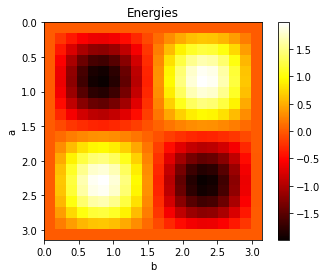

In [42]:
pos = plt.imshow(energies, cmap='hot', interpolation='nearest', extent=[0,alist[-1],blist[-1],0])

plt.title('Energies')
plt.ylabel('a')
plt.xlabel('b')
plt.colorbar(pos)

plt.show()

In [43]:
print("The smallest energy is: ", np.amin(energies)) #should be -2 in theory
arg = np.argmin(energies)
print(arg)
bmin= arg%20
amin= (arg)//20
print("Indices for the arrays are: (i: {} and j: {}) ".format(amin,bmin) )
print("Values for the indices are: (a: {} and b: {}) ".format(alist[amin],blist[bmin]))

The smallest energy is:  -1.986361026763916
105
Indices for the arrays are: (i: 5 and j: 5) 
Values for the indices are: (a: 0.8267349088394192 and b: 0.8267349088394192) 


In [44]:
print(np.where(energies == np.amin(energies))) #printing the pair of indices for which the min is achieved
# here this is (5,5) and (14,14)

(array([ 5, 14], dtype=int64), array([ 5, 14], dtype=int64))


In [45]:
test =simulator.simulate_expectation_values(ansatz(alist[14],alist[14]), observables=-cirq.Z(q0)*cirq.X(q1)-cirq.X(q0)*cirq.Z(q1) )[0]
print('Energy of ground state:', round(test.real,3))

Energy of ground state: -1.986


In [46]:
def entanglement_entropy(circ, simulator=cirq.Simulator()):

    result = simulator.simulate(circ)
    state = result.final_state_vector

    C = np.reshape(state, newshape=(2,2))

    u, s, vh = LA.svd(C)

    ent = 0
    for sigma in s:
        if sigma != 0:
            ent -= sigma**2 * log(sigma**2,2)

    return ent

In [47]:
#13
gs = ansatz(alist[amin],blist[bmin])
print(gs)

result = simulator.simulate(gs)
state = result.final_state_vector

print('=====================================')
print('Bra-ket notation for the wavefunction:')
print(result.dirac_notation())
print('=====================================')

#correct up to a global phase of e^(-ipi/2)
gs_state = np.array([1,1,1,-1])*0.5
print(gs_state)

print('Including the global phase and taking only the real part: ')
print((np.exp(-1j*np.pi/2)*state).real)
print(cirq.equal_up_to_global_phase(gs_state, state, atol=1))

entanglement_entropy(gs) #should be equal to 1 in theory





0: ───RZX(0.8267349088394192)───RXZ(0.8267349088394192)───Rz(-0.526π)───
      │                         │
1: ───RZX(0.8267349088394192)───RXZ(0.8267349088394192)───Rz(-0.526π)───
Bra-ket notation for the wavefunction:
(-0.04+0.46j)|00⟩ + 0.5j|01⟩ + 0.5j|10⟩ + (-0.04-0.54j)|11⟩
[ 0.5  0.5  0.5 -0.5]
Including the global phase and taking only the real part: 
[ 0.45714357  0.4982922   0.4982922  -0.5394409 ]
True


0.9901730365989556

In [48]:
# Exercise 15:

entanglement = np.empty(shape=(len(alist),len(blist)))

simulator = cirq.Simulator()

for i, a in enumerate(alist):
    for j, b in enumerate(blist):
        ansatz_state = ansatz(a,b)
        entanglement[i,j] = entanglement_entropy(ansatz_state, simulator)

        

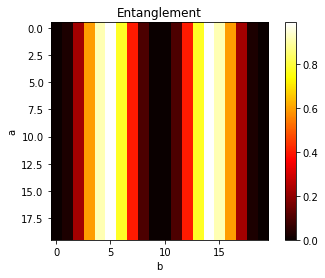

In [49]:
pos2 = plt.imshow(entanglement, cmap='hot', interpolation='nearest')

plt.title('Entanglement')
plt.ylabel('a')
plt.xlabel('b')
plt.colorbar(pos2)

plt.show()

In [50]:
print("The highest Entropy is: ", np.amax(entanglement))
arg = np.argmax(entanglement)
print('at',arg)
b= arg%20
a= (arg-b)//20
print("Indices in the arrays are: (i: {} and j: {}) ".format(a,b) )
print("Values for the indices are: (a: {} and b: {}) ".format(alist[a],blist[b]) )

The highest Entropy is:  0.9901730365989556
at 105
Indices in the arrays are: (i: 5 and j: 5) 
Values for the indices are: (a: 0.8267349088394192 and b: 0.8267349088394192) 


In [51]:
print(np.where(entanglement == np.amax(entanglement))) #printing the pair of indices for which the min is achieved

(array([ 5,  5, 14, 14], dtype=int64), array([ 5, 14,  5, 14], dtype=int64))


In [52]:
test = ansatz(alist[14],blist[5])
entanglement_entropy(test, simulator)

0.9901730365989556

the two ground states encountered coincid with points where entanglement is highest

# Not used:

In [53]:
def Troterization_noise(w,wo,w1,t):
    
    noise = cirq.ConstantQubitNoiseModel(cirq.GeneralizedAmplitudeDampingChannel(p=0.9,gamma=0.02))
    
    troter = U(w,wo,w1,t)
    
    reps = 10000
    
    troter.append(cirq.measure(q_chain[0]))
    result = cirq.sample(program=troter, noise=noise, repetitions=reps) # type(result) = <class 'cirq.study.result.ResultDict'>
    
    # other keys don't seem to work
    # type(histogram) = <class 'collections.Counter'>
    histogram = result.histogram(key = '0') 
    
    # _ = cirq.plot_state_histogram(histogram, plt.subplot())
    # plt.show()

    # population for state |1> := prob(measurement=1)
    population = histogram[1]/reps
    

In [54]:
# Test for entanglement entropy in a bell state

q0,q1 = cirq.LineQubit.range(2)

circ = cirq.Circuit(cirq.H(q0), cirq.CNOT(q0,q1))

print(circ)

result = simulator.simulate(circ)
state = result.final_state_vector

C = np.reshape(state, newshape=(2,2))

print(C)

u, s, vh = LA.svd(C)

ent = 0

for sigma in s:
    if sigma != 0:
        ent -= sigma**2 * log(sigma**2,2)

ent #should be equal to 1 by definition
#entanglement= cirq.von_neumann_entropy(density)
#print(entanglement)

0: ───H───@───
          │
1: ───────X───
[[0.70710677+0.j 0.        +0.j]
 [0.        +0.j 0.70710677+0.j]]


1.0000000151528048